In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/clean/energy_spain_clean.csv', parse_dates=['date'])

## Prophet para generación total eléctrica

In [3]:
df_prophet = df.rename(columns={'date':'ds', 'electricity_generation':'y'})[['ds','y']]
model_prophet = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
model_prophet.fit(df_prophet)

11:56:43 - cmdstanpy - INFO - Chain [1] start processing
11:56:43 - cmdstanpy - INFO - Chain [1] done processing


In [4]:
future = model_prophet.make_future_dataframe(periods=10, freq='Y')
forecast = model_prophet.predict(future)

C:\Users\frang\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


<Figure size 1000x600 with 0 Axes>

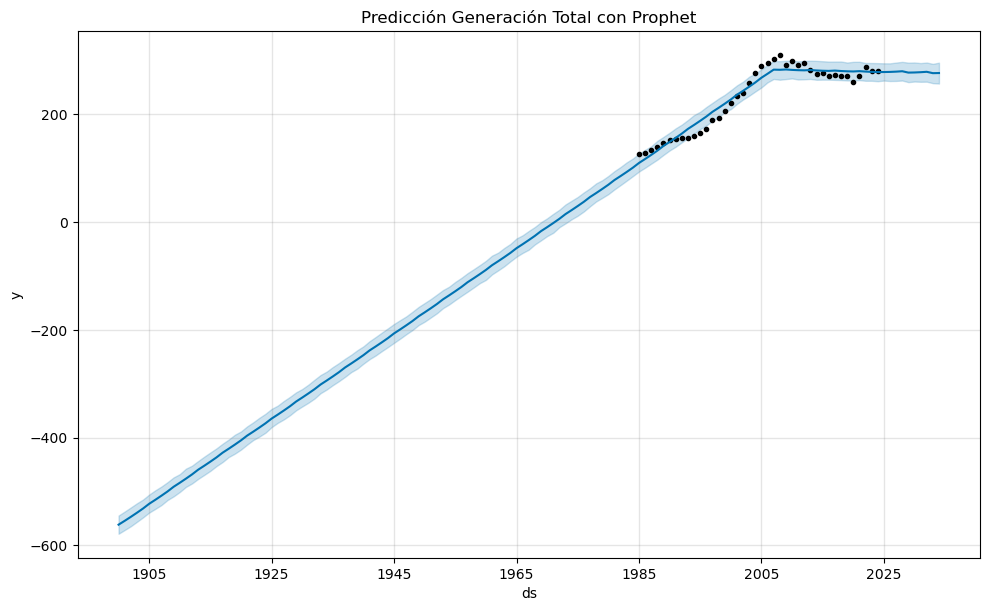

In [5]:
plt.figure(figsize=(10,6))
model_prophet.plot(forecast)
plt.title('Predicción Generación Total con Prophet')
plt.show()

In [6]:
joblib.dump(model_prophet, '../src/prophet_energy_model.joblib')

['../src/prophet_energy_model.joblib']

## Random Forest para predicción multivariante

In [7]:
# Variables predictoras y target
features = ['renewables_electricity', 'fossil_electricity', 'coal_electricity', 'gas_electricity', 
            'nuclear_electricity', 'oil_electricity', 'hydro_electricity', 'solar_electricity', 
            'wind_electricity', 'gdp', 'population']
target = 'electricity_generation'

In [8]:
df_rf = df.dropna(subset=features + [target])
X = df_rf[features]
y = df_rf[target]

In [9]:
# División temporal (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [10]:
model_rf = RandomForestRegressor(n_estimators=200, random_state=42)
model_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [11]:
y_pred = model_rf.predict(X_test)

In [12]:
print(f"MAE RF: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE RF: {mean_squared_error(y_test, y_pred):.2f}")

MAE RF: 13.21
MSE RF: 235.94


In [13]:
joblib.dump(model_rf, '../src/rf_energy_model.joblib')

['../src/rf_energy_model.joblib']

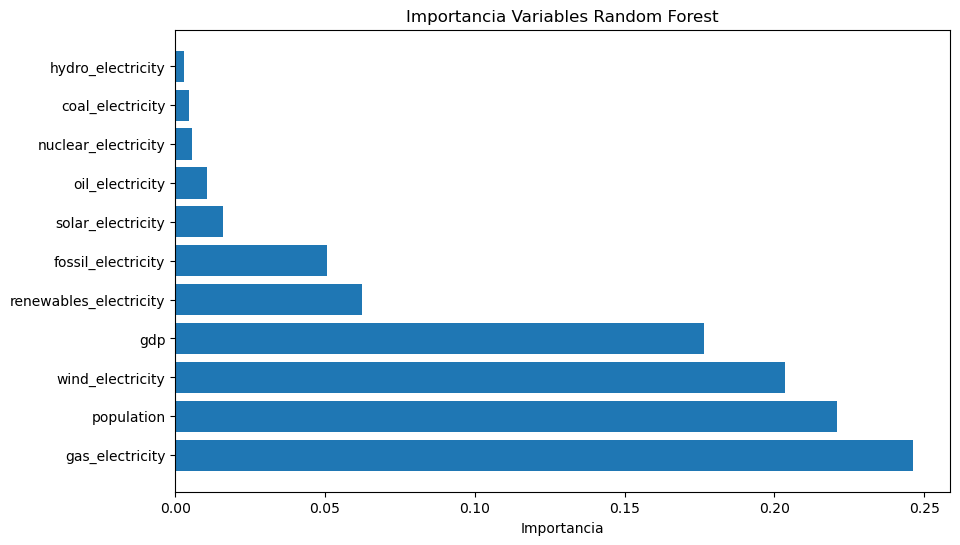

In [14]:
# Importancia de variables
importances = model_rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.barh([features[i] for i in sorted_idx], importances[sorted_idx])
plt.title('Importancia Variables Random Forest')
plt.xlabel('Importancia')
plt.show()